Train Regression (3 CLIP scores, and T -> predict best T) Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os
import random

random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
np.random.seed(random_seed)
random.seed(random_seed)

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Load Data

In [ ]:
save_path = Path('/home/lbw/CLODE_scores_npy')
# save_path = Path('/home/lbw/CLODE/scores_csv_15_45')

# (485, 2): 485개 이미지에 대한, best T값과 그때의 PSNR
results = np.load(save_path / 'results.npy')

# (485 * 30, 3): 485개 이미지에 대한, 30개의 T값에 대한 score. 3 = [idx, T, score]
brightness_scores = np.load(save_path / 'brightness_scores.npy')
noisiness_scores = np.load(save_path / 'noisiness_scores.npy')
quality_scores = np.load(save_path / 'quality_scores.npy')

print(results.shape, brightness_scores.shape, noisiness_scores.shape, quality_scores.shape)

(485, 2) (14550, 3) (14550, 3) (14550, 3)


In [3]:
print(brightness_scores[:31, 1])

[2.         2.10344828 2.20689655 2.31034483 2.4137931  2.51724138
 2.62068966 2.72413793 2.82758621 2.93103448 3.03448276 3.13793103
 3.24137931 3.34482759 3.44827586 3.55172414 3.65517241 3.75862069
 3.86206897 3.96551724 4.06896552 4.17241379 4.27586207 4.37931034
 4.48275862 4.5862069  4.68965517 4.79310345 4.89655172 5.
 2.        ]


In [4]:
NUM_IMAGES = results.shape[0]
NUM_T = 30

In [5]:
# from torchmetrics.multimodal import CLIPImageQualityAssessment
# from tqdm import tqdm
# from misc import *

# prompts = ('brightness', 'noisiness', 'quality')
# clip_metric = CLIPImageQualityAssessment(model_name_or_path="openai/clip-vit-base-patch16", prompts=prompts).to(device)

# file_path = Path('/home/soom/data/our485')
# img_labels = sorted(os.listdir(file_path / 'low'))

# def calculate_clip_scores(pred):    
#     clip_result = clip_metric(pred.unsqueeze(0) if len(pred.shape) == 3 else pred)
#     scores = [clip_result[prompt].item() for prompt in prompts]
    
#     return scores

# lq_iqa_scores = []

# with torch.no_grad():
#     for idx in tqdm(range(NUM_IMAGES)):
#         lq_t = image_tensor(file_path / 'low' / img_labels[idx], size=(256, 256))
#         scores = calculate_clip_scores(lq_t)
#         lq_iqa_scores.append(scores)

In [6]:
lq_iqa_scores = np.load(Path('/home/soom/CLODE/soom_npy_results') / 'lq_iqa_scores.npy')

In [7]:
X = np.zeros((NUM_IMAGES, NUM_T, 3))

for i in range(NUM_IMAGES):
    for j in range(NUM_T):
        X[i, j, 0] = brightness_scores[i * NUM_T + j, 2]
        X[i, j, 1] = noisiness_scores[i * NUM_T + j, 2]
        X[i, j, 2] = quality_scores[i * NUM_T + j, 2]

y = results[:, 0]

X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

print(X.shape, y.shape)

torch.Size([485, 30, 3]) torch.Size([485])


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([388, 30, 3]) torch.Size([97, 30, 3]) torch.Size([388]) torch.Size([97])


In [9]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

Load Model

In [10]:
class Regressor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super(Regressor, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            # nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            # nn.LayerNorm(hidden_dim),
        )

        self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim*2)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        # [batch_size, T, hidden_dim]
        x = self.mlp(x)
        # [seq_len = T, batch, hidden_dim]
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        # [batch, hidden_dim]
        x = x.permute(1, 0, 2).mean(dim=1)
        # [batch, 1]
        T_pred = self.fc(x).squeeze(-1)
        return T_pred

Train the Model

In [ ]:
from tqdm import tqdm

num_epochs = 2000
train_losses = []
test_losses = []
best_test_loss = 10
best_epoch = 0
learning_rate = 1e-4

regressor = Regressor(input_dim = 3, hidden_dim = 64).to(device)
criterion = torch.nn.HuberLoss(delta=1.0)
optimizer = optim.AdamW(regressor.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)


for epoch in tqdm(range(num_epochs)):
    regressor.train()
    epoch_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        y_pred = regressor(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    regressor.eval()
    test_loss = 0.0
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = regressor(X_batch)
            test_loss += criterion(y_pred, y_batch).item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = regressor.state_dict()
            best_epoch = epoch


model_path = Path("/home/lbw/CLODE/lbw_outputs")
model_path.mkdir(exist_ok=True, parents=True)

torch.save(best_model, (model_path / f'att_regression_{best_epoch}.pth'))
print(best_epoch)

/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 2000/2000 [08:00<00:00,  4.16it/s]

175


Plot Train Result and Performance

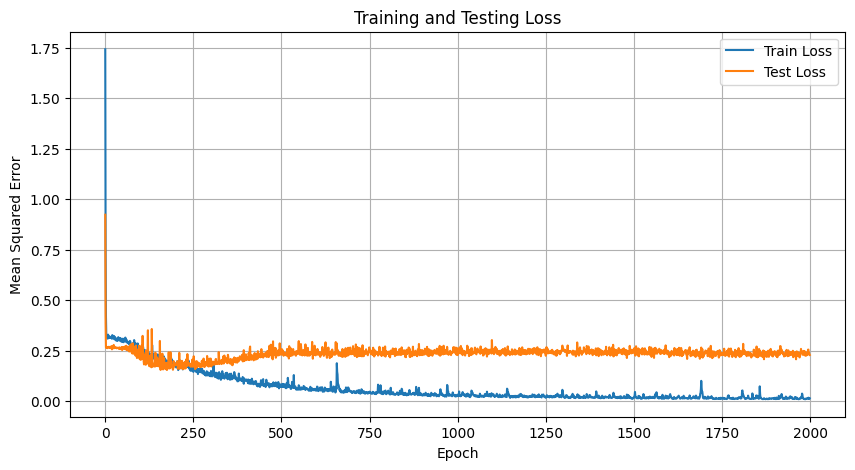

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig(model_path / 'regression_training.png')
plt.show()

MAE: 0.1766, RMSE: 0.2180


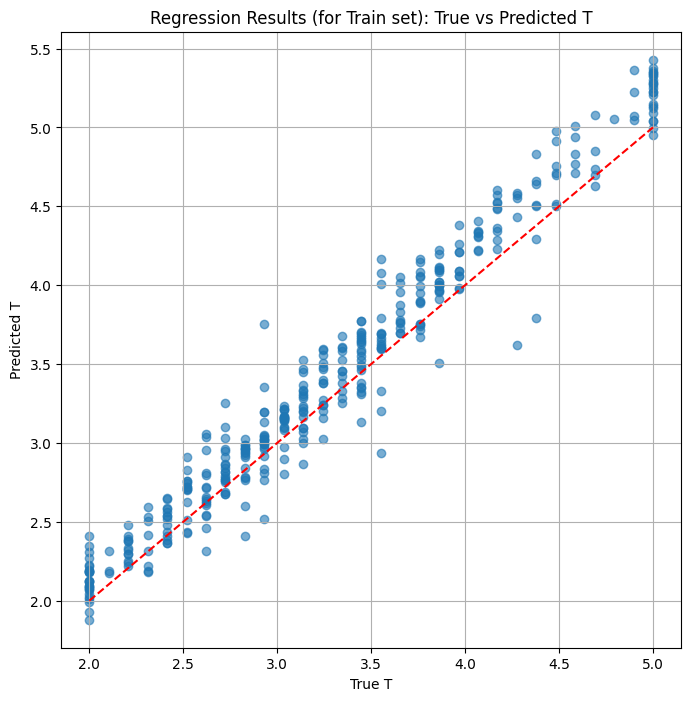

MAE: 0.5804, RMSE: 0.7442


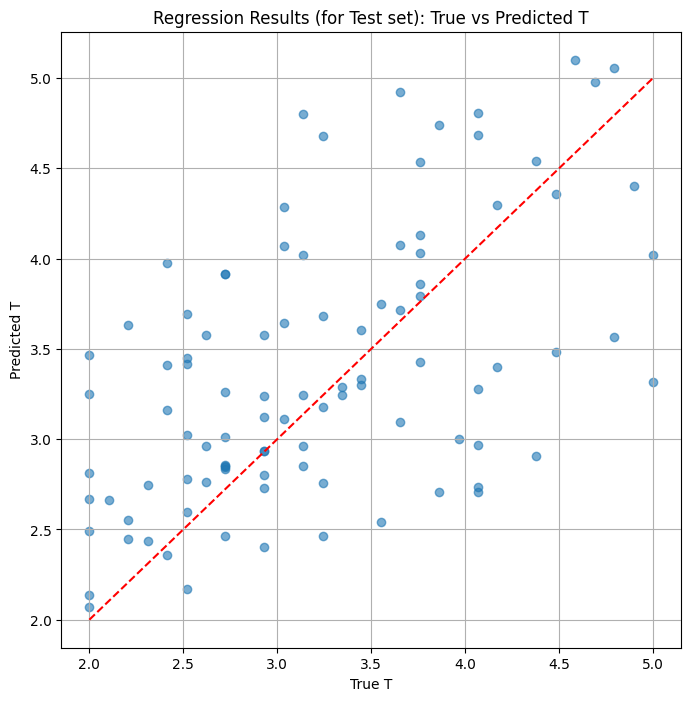

In [13]:
regressor.eval()

def plot_regression_results(y_true, y_pred, title):
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True T')
    plt.ylabel('Predicted T')
    plt.title(title)
    plt.grid(True)
    plt.show()

with torch.no_grad():
    y_pred = regressor(X_train).cpu().numpy()
    y_true = y_train.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Train set): True vs Predicted T')

    y_pred = regressor(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Test set): True vs Predicted T')

In [14]:
# import torch
# from tqdm import tqdm
# from network.conv_node import NODE
# # from network.clip_classifier import TtoTClassifier
# from misc import *
# import os
# from pathlib import Path
# import numpy as np
# import matplotlib.pyplot as plt
# from torchmetrics.multimodal import CLIPImageQualityAssessment
# import time
# from network.clip_regressor import TtoTRegressor
# from skimage.metrics import structural_similarity as ssim

# # GPU 번호 지정
# gpu_number = 0  # 원하는 GPU 번호로 변경 가능

# # GPU 사용 제한
# os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# # 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# model = NODE(device, (3, 256, 256), 32, augment_dim=0, time_dependent=True, adjoint=True)
# model.eval()
# model.to(device)
# model.load_state_dict(torch.load(f'/home/lbw/CLODE/pth/universal.pth', weights_only=True), strict=False)

# # 하이퍼파라미터 설정
# input_dim = 3
# hidden_dim = 128
# # num_layers = 3

# # 모델 초기화
# regressor = Regressor(input_dim, hidden_dim).to(device)
# regressor.eval()
# regressor.to(device)
# # model_path_name = '/home/lbw/CLODE_model/att_regression_64_0.0001_567.pth'
# regressor.load_state_dict(torch.load((model_path / f'att_regression_{best_epoch}.pth'), map_location=device))

# file_path = Path('/home/lbw/data/eval15')

# # img_labels = sorted(os.listdir(file_path / 'low'))
# img_labels = [f for f in sorted(os.listdir(file_path / 'low')) if f.lower().endswith('.png')]

# # 필요한 함수들 정의
# prompts = ('brightness', 'noisiness', 'quality')
# clip_metric = CLIPImageQualityAssessment(
#     model_name_or_path="openai/clip-vit-base-patch16",
#     prompts=prompts
# ).to(device)

# def calculate_clip_score(pred):    
#     if len(pred.shape) == 3:
#         pred = pred.unsqueeze(0)
    
#     with torch.no_grad():
#         scores = clip_metric(pred)
    
#     return scores[prompts[0]].item(), scores[prompts[1]].item(), scores[prompts[2]].item()

# # eval15 데이터 불러오기
# eval_path = Path('/home/lbw/data/eval15')
# eval_images = [f for f in sorted(os.listdir(eval_path / 'low')) if f.lower().endswith('.png')]

# def load_eval_image(idx):
#     img_name = eval_images[idx]
#     lq_img = image_tensor(eval_path / 'low' / img_name, size=(256, 256))
#     gt_img = image_tensor(eval_path / 'high' / img_name, size=(256, 256))
    
#     return lq_img.to(device), gt_img.to(device), img_name

# def tensor_to_numpy(tensor):
#     """PyTorch 텐서를 NumPy 배열로 변환합니다."""
#     # GPU -> CPU 이동 및 계산 그래프에서 분리
#     img = tensor.detach().cpu().numpy()
    
#     # 이미지 형식 변환 (C,H,W) -> (H,W,C)
#     if img.ndim == 3 and img.shape[0] == 3:
#         img = np.transpose(img, (1, 2, 0))
    
#     # 값 범위 조정 [0, 1]
#     img = np.clip(img, 0, 1)
    
#     return img

# def calculate_ssim(img1, img2):
#     """
#     두 이미지 간의 SSIM(구조적 유사성) 계산
    
#     Args:
#         img1 (torch.Tensor): 첫 번째 이미지 텐서
#         img2 (torch.Tensor): 두 번째 이미지 텐서
        
#     Returns:
#         float: SSIM 값 (0~1 사이, 1이 가장 유사함)
#     """
#     # GPU 텐서를 CPU로 이동 후 NumPy 배열로 변환
#     # 차원 확인 및 정규화
#     if len(img1.shape) == 4:  # (B,C,H,W) 형태인 경우
#         img1 = img1[0]  # (C,H,W) 형태로 변경
#     if len(img2.shape) == 4:  # (B,C,H,W) 형태인 경우
#         img2 = img2[0]  # (C,H,W) 형태로 변경
    
#     img1_np = tensor_to_numpy(img1)
#     img2_np = tensor_to_numpy(img2)
    
#     # tensor_to_numpy 함수를 통해 이미 (H,W,C) 형태로 변환되었으므로
#     # channel_axis는 2로 설정
#     return ssim(img1_np, img2_np, channel_axis=2, data_range=1.0)

# # 메인 루프 최적화
# T_values = np.linspace(2, 5, 30)

# # T 값들을 먼저 텐서로 변환하여 반복 변환 방지
# T_tensors = [torch.tensor([0, T]).float().cuda() for T in T_values]

# # 결과 저장을 위한 디렉토리 생성
# results_dir = Path(f'/home/lbw/CLODE_eval_results_atten_{best_epoch}')
# results_dir.mkdir(parents=True, exist_ok=True)

# best_Ts = []
# pred_Ts = []
# best_psnrs = []
# pred_psnrs = []
# best_ssims = []  # SSIM 결과 저장용
# pred_ssims = []  # SSIM 결과 저장용

# # 이미지별 NODE와 Classifier 결과 비교
# for idx in tqdm(range(len(eval_images))):
#     lq_img, gt_img, img_name = load_eval_image(idx)
    
#     # 모든 T에 대한 예측 수행
#     preds = []
#     psnrs = []
#     ssims = []  # SSIM 값 저장 리스트
    
#     with torch.no_grad():
#         for T_tensor in T_tensors:
#             pred = model(lq_img, T_tensor, inference=True)['output'][0]
#             preds.append(pred)
#             psnr = calculate_psnr(pred, gt_img).item()
#             psnrs.append(psnr)
#             # SSIM 계산 추가
#             ssim_value = calculate_ssim(pred, gt_img)
#             ssims.append(ssim_value)
    
    
#     # PSNR 기반 best_T 찾기
#     best_T_idx = np.argmax(psnrs)
#     best_T = T_values[best_T_idx]
#     best_pred = preds[best_T_idx]
    
#     best_Ts.append(best_T)
#     best_psnrs.append(psnrs[best_T_idx])
#     best_ssims.append(ssims[best_T_idx])  # 최적 T의 SSIM 저장
    
    
#     # CLIP 점수 계산 및 행렬 구성
#     clip_scores = np.zeros((len(preds), 3))
#     for i, pred in enumerate(preds):
#         bright_score, noise_score, quality_score = calculate_clip_score(pred)
#         clip_scores[i] = [bright_score, noise_score, quality_score]
    
#     # Classifier 모델로 예측
#     clip_scores_tensor = torch.FloatTensor(clip_scores).unsqueeze(0).to(device)  # (1, T, 3) 형태로 변환
#     with torch.no_grad():
#         pred_T = regressor(clip_scores_tensor)
#         pred_T = pred_T.item()
        
    
#     pred_T_idx = np.argmin(np.abs(T_values - pred_T))
#     pred_img = preds[pred_T_idx]
    
#     pred_Ts.append(pred_T)
#     pred_psnrs.append(psnrs[pred_T_idx])
#     pred_ssims.append(ssims[pred_T_idx])  # 예측 T의 SSIM 저장
    
    
#     # 시각화
#     plt.figure(figsize=(20, 15))
    
#     # 원본 저화질 이미지
#     plt.subplot(2, 2, 1)
#     plt.imshow(tensor_to_numpy(lq_img[0]))
#     plt.title(f'Low Quality Image: {img_name}')
#     plt.axis('off')
    
#     # 원본 고화질 이미지
#     plt.subplot(2, 2, 2)
#     plt.imshow(tensor_to_numpy(gt_img[0]))
#     plt.title('Ground Truth')
#     plt.axis('off')
    
#     # PSNR 기반 best_T 이미지
#     plt.subplot(2, 2, 3)
#     plt.imshow(tensor_to_numpy(best_pred))
#     plt.title(f'NODE Best T={best_T:.2f}, PSNR={psnrs[best_T_idx]:.2f}dB, SSIM={ssims[best_T_idx]:.4f}')
#     plt.axis('off')
    
#     # Regressor 예측 T 이미지
#     plt.subplot(2, 2, 4)
#     plt.imshow(tensor_to_numpy(pred_img))
#     plt.title(f'Regressor Pred T={pred_T:.2f}, PSNR={psnrs[pred_T_idx]:.2f}dB, SSIM={ssims[pred_T_idx]:.4f}')
#     plt.axis('off')
    
#     # 결과 저장
#     plt.tight_layout()
#     plt.savefig(results_dir / f'{img_name.split(".")[0]}_compare.png')
#     plt.close()

# # 통계 정보 계산 (전체 이미지에 대해)
# print("모든 이미지 처리 완료!")

# # best_Ts와 pred_Ts를 하나의 플롯에 시각화
# plt.figure(figsize=(10, 6))
# plt.plot(best_Ts, label='Best Ts (PSNR-based)', marker='o')
# plt.plot(pred_Ts, label='Predicted Ts (Regressor-based)', marker='x')
# plt.xlabel('Image Index')
# plt.ylabel('T Values')
# plt.title('Comparison of Best Ts and Predicted Ts')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(results_dir / 'best_vs_pred_Ts.png')
# plt.show()

# # PSNR 비교
# print(f"Best T PSNR 평균: {np.mean(best_psnrs):.2f}dB")
# print(f"Predicted T PSNR 평균: {np.mean(pred_psnrs):.2f}dB")
# print(f"Best T SSIM 평균: {np.mean(best_ssims):.4f}")
# print(f"Predicted T SSIM 평균: {np.mean(pred_ssims):.4f}")


In [15]:
import torch
from tqdm import tqdm
from network.conv_node import NODE
# from network.clip_classifier import TtoTClassifier
from misc import *
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.multimodal import CLIPImageQualityAssessment
import time
from network.clip_regressor import TtoTRegressor
from skimage.metrics import structural_similarity as ssim
import pickle

# GPU 번호 지정
gpu_number = 0  # 원하는 GPU 번호로 변경 가능

# GPU 사용 제한
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 결과 저장 및 로드를 위한 디렉토리 설정
results_save_dir = Path('/home/lbw/eval_CLODE_results')
results_save_dir.mkdir(parents=True, exist_ok=True)

# 시각화 결과 저장 디렉토리
results_dir = Path('/home/lbw/CLODE_eval_results_atten')
results_dir.mkdir(parents=True, exist_ok=True)

# 결과 파일 경로 설정
node_results_file = results_save_dir / 'node_eval_results.pkl'

# 필요한 함수들 정의
def tensor_to_numpy(tensor):
    """PyTorch 텐서를 NumPy 배열로 변환합니다."""
    # GPU -> CPU 이동 및 계산 그래프에서 분리
    img = tensor.detach().cpu().numpy()
    
    # 이미지 형식 변환 (C,H,W) -> (H,W,C)
    if img.ndim == 3 and img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    
    # 값 범위 조정 [0, 1]
    img = np.clip(img, 0, 1)
    
    return img

def calculate_ssim(img1, img2):
    """
    두 이미지 간의 SSIM(구조적 유사성) 계산
    """
    # GPU 텐서를 CPU로 이동 후 NumPy 배열로 변환
    # 차원 확인 및 정규화
    if len(img1.shape) == 4:  # (B,C,H,W) 형태인 경우
        img1 = img1[0]  # (C,H,W) 형태로 변경
    if len(img2.shape) == 4:  # (B,C,H,W) 형태인 경우
        img2 = img2[0]  # (C,H,W) 형태로 변경
    
    img1_np = tensor_to_numpy(img1)
    img2_np = tensor_to_numpy(img2)
    
    # tensor_to_numpy 함수를 통해 이미 (H,W,C) 형태로 변환되었으므로
    # channel_axis는 2로 설정
    return ssim(img1_np, img2_np, channel_axis=2, data_range=1.0)

# CLIP 점수 계산을 위한 설정
prompts = ('brightness', 'noisiness', 'quality')
clip_metric = CLIPImageQualityAssessment(
    model_name_or_path="openai/clip-vit-base-patch16",
    prompts=prompts
).to(device)

def calculate_clip_score(pred):    
    if len(pred.shape) == 3:
        pred = pred.unsqueeze(0)
    
    with torch.no_grad():
        scores = clip_metric(pred)
    
    return scores[prompts[0]].item(), scores[prompts[1]].item(), scores[prompts[2]].item()

# eval15 데이터 경로 설정
eval_path = Path('/home/lbw/data/eval15')
eval_images = [f for f in sorted(os.listdir(eval_path / 'low')) if f.lower().endswith('.png')]

def load_eval_image(idx):
    img_name = eval_images[idx]
    lq_img = image_tensor(eval_path / 'low' / img_name, size=(256, 256))
    gt_img = image_tensor(eval_path / 'high' / img_name, size=(256, 256))
    
    return lq_img.to(device), gt_img.to(device), img_name

/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


저장된 NODE 결과를 /home/lbw/eval_CLODE_results/node_eval_results.pkl에서 로드합니다.


/tmp/ipykernel_3894414/3882958352.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  regressor.load_state_dict(torch.load(model_path_name, map_location=device))


NODE 결과 로드 완료!


회귀 모델 평가 중: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


모든 이미지 처리 완료!


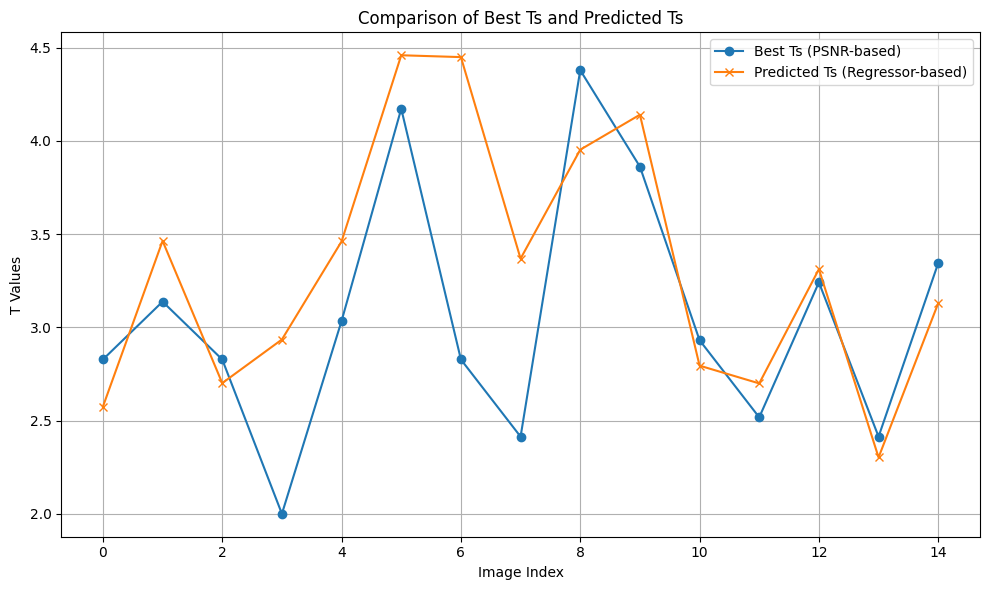

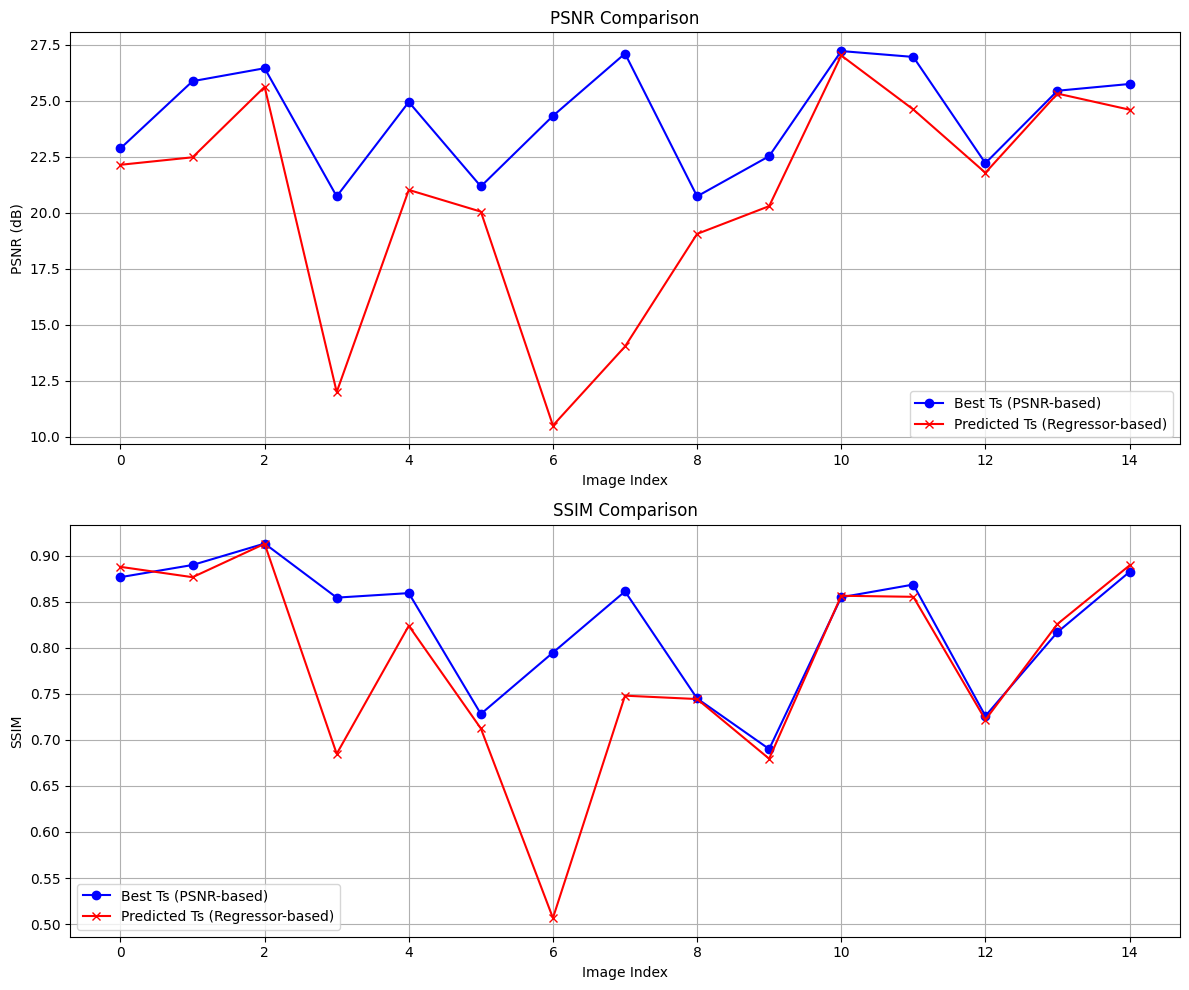

Best T PSNR 평균: 24.2928dB
Predicted T PSNR 평균: 20.7069dB
Best T SSIM 평균: 0.8241
Predicted T SSIM 평균: 0.7817
PSNR 차이(평균): 3.5859dB
SSIM 차이(평균): 0.0424


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm

# 저장된 NODE 결과 로드
try:
    print(f"저장된 NODE 결과를 {node_results_file}에서 로드합니다.")
    with open(node_results_file, 'rb') as f:
        node_results = pickle.load(f)
    print("NODE 결과 로드 완료!")
    
    # T값 로드
    T_values = node_results['T_values']
    
except FileNotFoundError:
    print(f"결과 파일({node_results_file})을 찾을 수 없습니다.")
    print("NODE 모델 결과를 먼저 생성해야 합니다.")
except Exception as e:
    print(f"결과 로드 중 오류 발생: {e}")

# 하이퍼파라미터 설정
input_dim = 3
hidden_dim = 64
# num_layers = 3

# 회귀 모델 초기화
regressor = Regressor(input_dim, hidden_dim).to(device)
regressor.eval()
model_path_name = (model_path / f'att_regression_{best_epoch}.pth')
regressor.load_state_dict(torch.load(model_path_name, map_location=device))

# 결과 저장 리스트
best_Ts = []
pred_Ts = []
best_psnrs = []
pred_psnrs = []
best_ssims = []
pred_ssims = []

# 이미지별 회귀 모델 평가
for img_idx, img_result in enumerate(tqdm(node_results['results'], desc="회귀 모델 평가 중")):
    img_name = img_result['img_name']
    
    # NODE 결과에서 정보 추출
    best_T_idx = img_result['best_T_idx']
    best_T = img_result['best_T']
    best_psnr = img_result['psnrs'][best_T_idx]
    best_ssim = img_result['ssims'][best_T_idx]
    
    # 결과 저장
    best_Ts.append(best_T)
    best_psnrs.append(best_psnr)
    best_ssims.append(best_ssim)
    
    # CLIP 점수로 T값 예측
    clip_scores = np.array(img_result['clip_scores'])
    clip_scores_tensor = torch.FloatTensor(clip_scores).unsqueeze(0).to(device)  # (1, T, 3)
    
    with torch.no_grad():
        pred_T = regressor(clip_scores_tensor)
        pred_T = pred_T.item()
    
    # 가장 가까운 T값 인덱스 찾기
    pred_T_idx = np.argmin(np.abs(T_values - pred_T))
    
    # 예측 결과 저장
    pred_Ts.append(pred_T)
    pred_psnrs.append(img_result['psnrs'][pred_T_idx])
    pred_ssims.append(img_result['ssims'][pred_T_idx])
    
    # 결과 시각화
    plt.figure(figsize=(20, 15))
    
    # 원본 저화질 이미지
    plt.subplot(2, 2, 1)
    plt.imshow(img_result['lq_img'])
    plt.title(f'Low Quality Image: {img_name}')
    plt.axis('off')
    
    # 원본 고화질 이미지
    plt.subplot(2, 2, 2)
    plt.imshow(img_result['gt_img'])
    plt.title('Ground Truth')
    plt.axis('off')
    
    # PSNR 기반 best_T 이미지
    plt.subplot(2, 2, 3)
    plt.imshow(img_result['preds'][best_T_idx])
    plt.title(f'NODE Best T={best_T:.2f}, PSNR={best_psnr:.2f}dB, SSIM={best_ssim:.4f}')
    plt.axis('off')
    
    # Regressor 예측 T 이미지
    plt.subplot(2, 2, 4)
    plt.imshow(img_result['preds'][pred_T_idx])
    plt.title(f'Regressor Pred T={pred_T:.2f}, PSNR={img_result["psnrs"][pred_T_idx]:.2f}dB, SSIM={img_result["ssims"][pred_T_idx]:.4f}')
    plt.axis('off')
    
    # 결과 저장
    plt.tight_layout()
    plt.savefig(results_dir / f'{img_name.split(".")[0]}_compare.png')
    plt.close()

# 통계 정보 계산 (전체 이미지에 대해)
print("모든 이미지 처리 완료!")

# best_Ts와 pred_Ts를 하나의 플롯에 시각화
plt.figure(figsize=(10, 6))
plt.plot(best_Ts, label='Best Ts (PSNR-based)', marker='o')
plt.plot(pred_Ts, label='Predicted Ts (Regressor-based)', marker='x')
plt.xlabel('Image Index')
plt.ylabel('T Values')
plt.title('Comparison of Best Ts and Predicted Ts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(results_dir / 'best_vs_pred_Ts.png')
plt.show()

# PSNR과 SSIM 결과를 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# PSNR 비교 그래프
ax1.plot(best_psnrs, label='Best Ts (PSNR-based)', marker='o', color='blue')
ax1.plot(pred_psnrs, label='Predicted Ts (Regressor-based)', marker='x', color='red')
ax1.set_xlabel('Image Index')
ax1.set_ylabel('PSNR (dB)')
ax1.set_title('PSNR Comparison')
ax1.legend()
ax1.grid(True)

# SSIM 비교 그래프
ax2.plot(best_ssims, label='Best Ts (PSNR-based)', marker='o', color='blue')
ax2.plot(pred_ssims, label='Predicted Ts (Regressor-based)', marker='x', color='red')
ax2.set_xlabel('Image Index')
ax2.set_ylabel('SSIM')
ax2.set_title('SSIM Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(results_dir / 'metrics_comparison.png')
plt.show()

# 성능 통계 출력
print(f"Best T PSNR 평균: {np.mean(best_psnrs):.4f}dB")
print(f"Predicted T PSNR 평균: {np.mean(pred_psnrs):.4f}dB")
print(f"Best T SSIM 평균: {np.mean(best_ssims):.4f}")
print(f"Predicted T SSIM 평균: {np.mean(pred_ssims):.4f}")
print(f"PSNR 차이(평균): {np.mean(best_psnrs) - np.mean(pred_psnrs):.4f}dB")
print(f"SSIM 차이(평균): {np.mean(best_ssims) - np.mean(pred_ssims):.4f}")

In [ ]:
if

In [ ]:
# NODE 모델 로드
model = NODE(device, (3, 256, 256), 32, augment_dim=0, time_dependent=True, adjoint=True)
model.eval()
model.to(device)
model.load_state_dict(torch.load(f'/home/lbw/CLODE/pth/universal.pth', weights_only=True), strict=False)

# T값 범위 설정
T_values = np.linspace(2, 5, 30)
T_tensors = [torch.tensor([0, T]).float().cuda() for T in T_values]

# 결과 저장할 딕셔너리
node_results = {
    'T_values': T_values,
    'results': []
}

# 이미지별 NODE 모델 처리
for idx in tqdm(range(len(eval_images)), desc="NODE 모델 결과 생성 중"):
    lq_img, gt_img, img_name = load_eval_image(idx)
    
    # 이미지별 결과 저장
    img_result = {
        'img_name': img_name,
        'lq_img': tensor_to_numpy(lq_img[0]),
        'gt_img': tensor_to_numpy(gt_img[0]),
        'preds': [],
        'psnrs': [],
        'ssims': [],
        'clip_scores': []
    }
    
    # 모든 T에 대한 예측 수행
    with torch.no_grad():
        for T_tensor in T_tensors:
            pred = model(lq_img, T_tensor, inference=True)['output'][0]
            
            # 메트릭 계산
            psnr = calculate_psnr(pred, gt_img).item()
            ssim_value = calculate_ssim(pred, gt_img)
            bright_score, noise_score, quality_score = calculate_clip_score(pred)
            
            # 결과 저장
            img_result['preds'].append(tensor_to_numpy(pred))
            img_result['psnrs'].append(psnr)
            img_result['ssims'].append(ssim_value)
            img_result['clip_scores'].append([bright_score, noise_score, quality_score])
    
    # 최적 T 찾기
    best_T_idx = np.argmax(img_result['psnrs'])
    img_result['best_T_idx'] = best_T_idx
    img_result['best_T'] = T_values[best_T_idx]
    img_result['best_psnr'] = img_result['psnrs'][best_T_idx]
    img_result['best_ssim'] = img_result['ssims'][best_T_idx]
    
    # 이미지 결과 추가
    node_results['results'].append(img_result)

# 결과 저장
with open(node_results_file, 'wb') as f:
    pickle.dump(node_results, f)

print(f"NODE 모델 결과가 {node_results_file}에 저장되었습니다.")